# LSTM

In [16]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple tensorflow

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 199.0 MB 36 kB/s  eta 0:00:01    |████████████                    | 74.3 MB 2.5 MB/s eta 0:00:51     |████████████████████████▎       | 151.2 MB 4.4 MB/s eta 0:00:11     |████████████████████████████    | 173.5 MB 5.9 MB/s eta 0:00:05     |███████████████████████████████▌| 195.7 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.1 MB/s eta 0:00:011
     |████████████████████████████████| 3.9 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 2.1 MB/s eta 0:00:011
     |████████████████████████████████| 57 kB 3.8 MB/s eta 0:00:011
     |████████████████████████████████| 462 kB 1.5 

     |████████████████████████████████| 77 kB 610 kB/s eta 0:00:011
     |████████████████████████████████| 146 kB 590 kB/s eta 0:00:01
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30702 sha256=f3c8e3cb44c0a315f391f1667ee63e03011b29a281d6936e0b47cc095386751d
  Stored in directory: /Users/wangyibo06/Library/Caches/pip/wheels/21/22/c5/05c2b39e974d5310054631b6719dd28f0f0f9cafdd2da2770b
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=3e6503b9d806b361de76083ea35160a7b8c98195bc3c5199ee8ca3829ac8189a
  Stored in directory: /Users/wangyibo06/Library/Caches/pip/wheels/e3/de/40/cc69e66c496ef6bfe23010d31ca5584a6d58ab4cf2f5b5a187
Successfully built clang termcolor
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully 

# 1、data extract

In [1]:
import json

In [2]:
def prepare_data(filename):
    """
    args: 
        data: {user_id:{"text":text,"user":user,"place_id":place_id}}
     
    return:
        result: {text: [text1,text2,...],length:[length1,length2,...],label:[rumor or not,...] } 
    """
    with open(filename, 'r') as obj:
        for line in obj.readlines():
            data = json.loads(line)
    result = {}
    text = []
    textlabel = []
    length = []
    for user_id in data.keys():
        text.append(data[user_id]['text'])
        textlabel.append(data[user_id]['place_id']) 
        length.append(len(data[user_id]['text']))
    result['text'] = text
    result['length'] = length
    result['label'] = textlabel
    return result

In [3]:
file = './train_dev_data/0905_1005.txt'
train_dev = prepare_data(file)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
train_dev_df = pd.DataFrame(train_dev)
train_dev_df.head()

,text,length,label
0,Just posted a photo @ West End https://t.co/se...,54,4
1,"Just posted a photo @ Caulfield North, Victori...",2384,3
2,WATERCOLOUR ART CLASSES ONLINE Thursday 9 Sep...,280,1
3,Just posted a photo @ Centennial Parklands htt...,1641,1
4,Just posted a photo @ Richmond Hill Angus http...,264,11


In [100]:
#split the train_dev dataset
from sklearn.model_selection import train_test_split
x_processed = train_dev_df['text']
y_processed = train_dev_df['label']+1
x_train,x_dev,y_train,y_dev = train_test_split(x_processed,y_processed,test_size = 0.3,stratify = y_processed,random_state = 22)

In [88]:
print(set(y_processed))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, -1}


In [101]:
print(len(x_train))
print(len(x_dev))
print(y_train.head())

2132
915
121     2
1473    1
1741    5
2189    6
2666    2
Name: label, dtype: int64


In [90]:
print(len(x_train.iloc[:].values))

2132


In [102]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [91]:
# le.transform({-1}).reshape(-1,1)
print(type(y_dev))

<class 'pandas.core.series.Series'>


In [103]:
## encode the label in the dataset
train_y = y_train
dev_y = y_dev
le = LabelEncoder()
train_y = le.fit_transform(train_y).reshape(-1,1)
dev_y = le.transform(dev_y).reshape(-1,1)

## using the one-hot to encode the label
ohe = OneHotEncoder()
train_y = ohe.fit_transform(train_y).toarray()
dev_y = ohe.transform(dev_y).toarray()
# print(train_y)

In [74]:
print(train_y)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [104]:
## use Tokenizer to encode the text
## when we have an object of Tokenizer, we use the fit_on_texts() of this object to recognize the text
##it can number word in the text.The number is based on the word frequency. The higher the word frequency,
## the smaller the number
max_words = 5000
# change to 5000
max_len = 500
tok = Tokenizer(num_words=max_words)  ## max words is 5000
# tok = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tok.fit_on_texts(x_train)

## use the word_index attribute to see word number
##use the word_counts attribute to see word frequency
for ii,iterm in enumerate(tok.word_index.items()):
    if ii < 10:
        print(iterm)
    else:
        break
print("===================")  
for ii,iterm in enumerate(tok.word_counts.items()):
    if ii < 10:
        print(iterm)
    else:
        break

('co', 1)
('t', 2)
('https', 3)
('a', 4)
('bong', 5)
('posted', 6)
('photo', 7)
('australia', 8)
('the', 9)
('1', 10)
('sydneylockdown', 9)
('our', 211)
('beautiful', 80)
('city', 54)
('isolating', 2)
('until', 14)
('we', 166)
('meet', 15)
('again', 49)
("can't", 15)


In [39]:
print(len(tok.word_index))

30063


In [105]:
## after the word encoding, each word in the text can be represented by the number
## ie. each text can be converted to a vector
train_seq = tok.texts_to_sequences(x_train)
dev_seq = tok.texts_to_sequences(x_dev)
# test_seq = tok.texts_to_sequences(test_df.text)

## Adjust each sequence to the same length
train_seq_mat = sequence.pad_sequences(train_seq,maxlen=max_len)
dev_seq_mat = sequence.pad_sequences(dev_seq,maxlen=max_len)
# test_seq_mat = sequence.pad_sequences(test_seq,maxlen=max_len)
print(train_seq_mat.shape)
print(dev_seq_mat.shape)
# print(test_seq_mat.shape)

(2132, 500)
(915, 500)


In [106]:
## construct the LSTM Model
inputs = Input(name='inputs',shape=[max_len])

## Embedding(vocab size, batch size,each text length)
layer = Embedding(max_words+1,128,input_length=max_len)(inputs)
layer = LSTM(128)(layer)
layer = Dense(128,activation="relu",name="FC1")(layer)
layer = Dropout(0.5)(layer)
layer = Dense(17,activation="softmax",name="FC2")(layer)
model = Model(inputs=inputs,outputs=layer)
model.summary()



model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 500)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 500, 128)          640128    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
FC1 (Dense)                  (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
FC2 (Dense)                  (None, 17)                2193      
Total params: 790,417
Trainable params: 790,417
Non-trainable params: 0
_____________________________________________________

In [107]:
## save the model
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='lstm_model_max_5k_len_500.h5'
checkpoint=ModelCheckpoint(filepath,
                          monitor='val_accuracy',
                          verbose=0,
                          save_best_only=True,
                          save_weights_only=False,
                          mode='auto',
#                           save_freq=1
                          )
callbacks_list=[checkpoint]

In [111]:
## model training
from sklearn.utils import class_weight
class_weights=class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
# model_fit = model.fit(train_seq_mat,train_y,batch_size=128,epochs=10,class_weight=class_weights,
#                       validation_data=(dev_seq_mat,dev_y),
#                       callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.00001)] ## 当val-loss不再提升时停止训练
#                      )
model_fit = model.fit(train_seq_mat,train_y,batch_size=128,epochs=10,
                      validation_data=(dev_seq_mat,dev_y)
#                       callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.00001)]
                      ## 当val-loss不再提升时停止训练
                     )
# model_fit = model.fit(train_seq_mat,train_y,batch_size=128,epochs=10,class_weight=class_weights,
#                       validation_data=(dev_seq_mat,dev_y),
#                       callbacks=callbacks_list ## 当val-loss不再提升时停止训练
#                      )

/Users/wangyibo06/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16], y=121      2
1473     1
1741     5
2189     6
2666     2
        ..
2767     2
155     15
2387     4
376      1
2760     2
Name: label, Length: 2132, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 1/10
17/17 [==============================] - 18s 1s/step - loss: 1.1330 - accuracy: 0.6290 - val_loss: 1.8659 - val_accuracy: 0.4459
Epoch 2/10
17/17 [==============================] - 18s 1s/step - loss: 1.0178 - accuracy: 0.6750 - val_loss: 1.9430 - val_accuracy: 0.4492
Epoch 3/10
17/17 [==============================] - 18s 1s/step - loss: 0.9579 - accuracy: 0.6867 - val_loss: 2.0354 - val_accuracy: 0.4546
Epoch 4/10
17/17 [==============================] - 18s 1s/step - loss: 0.8749 - accuracy: 0.7265 - val_loss: 2.0523 - val_accuracy: 0.4699
Epoch 5/10
17/17 [==============================] - 18s 1s/step - loss: 0.7672 - accuracy: 0.7688 - val_loss: 2.3828 - val_accuracy: 0.4033
Epoch 6/10
17/17 [==============================] - 18s 1s/step - loss: 0.7173 - accuracy: 0.7763 - val_loss: 2.5031 - val_accuracy: 0.4404
Epoch 7/10
17/17 [==============================] - 18s 1s/step - loss: 0.6767 - accuracy: 0.7894 - val_loss: 2.3529 - val_accuracy: 0.4634
Epoch 8/10
17/17 [==

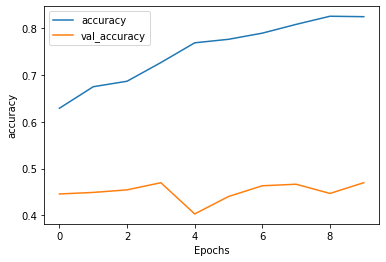

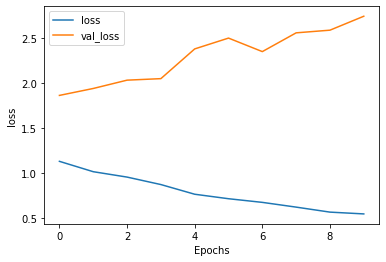

In [112]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(model_fit, "accuracy")
plot_graphs(model_fit, "loss")

In [80]:
Labname=[str(i) for i in range(16)]
Labname.append('-1')
print(Labname)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '-1']


In [99]:
print(dev_y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


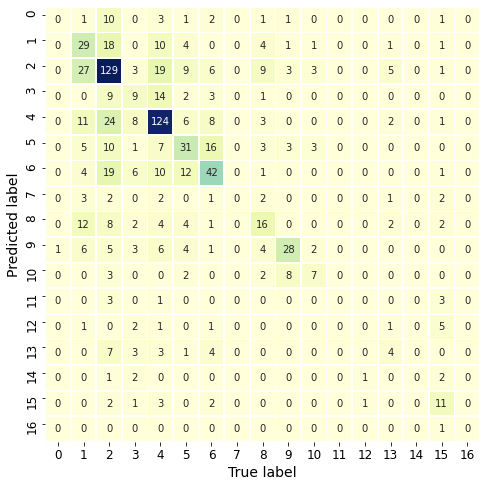

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.29      0.42      0.35        69
           2       0.52      0.60      0.56       214
           3       0.23      0.24      0.23        38
           4       0.60      0.66      0.63       187
           5       0.41      0.39      0.40        79
           6       0.48      0.44      0.46        95
           7       0.00      0.00      0.00        13
           8       0.35      0.31      0.33        51
           9       0.64      0.47      0.54        60
          10       0.44      0.32      0.37        22
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00        11
          13       0.25      0.18      0.21        22
          14       0.00      0.00      0.00         6
          15       0.35      0.55      0.43        20
          16       0.00      0.00      0.00         1

    accuracy              

/Users/wangyibo06/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wangyibo06/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wangyibo06/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
from sklearn import metrics
##evaluate on dev
## predict on dev
dev_pre = model.predict(dev_seq_mat)

# evaluate the performance of prediction , calculate the confusion_matrix
confm = metrics.confusion_matrix(np.argmax(dev_pre,axis=1),np.argmax(dev_y,axis=1))
## Confusion matrix visualization
Labname=[str(i) for i in range(17)]
# Labname.append('-1')
# print(Labname)
# Labname=[].append(str(i) for i in range(17))
plt.figure(figsize=(8,8))
sns.heatmap(confm.T, square=True, annot=True,
            fmt='d', cbar=False,linewidths=.8,
            cmap="YlGnBu")
plt.xlabel('True label',size = 14)
plt.ylabel('Predicted label',size = 14)
plt.xticks(np.arange(17)+0.5,Labname,size = 12)
plt.yticks(np.arange(17)+0.3,Labname,size = 12)
plt.show()

# print(np.argmax(dev_pre,axis=1))

print(metrics.classification_report(np.argmax(dev_y,axis=1),np.argmax(dev_pre,axis=1)))

In [52]:
print('best_n:',best_max_n,'best_features:',best_features,'best_score:%.4f'%best_score)

best_n: 5 best_features: 4000 best_score:0.4096


In [39]:
import joblib
# 模型存储
joblib.dump(best_clf, 'tfidf-lr_ngram{}_features{}_score{}.pkl'.format(best_max_n,best_features,best_score))

['tfidf-lr_ngram5_features4000_score0.40955266149151254.pkl']

In [16]:
best_max_n = 5
best_features = 4000

In [17]:
from sklearn import metrics
import numpy as np
tfidf = TfidfVectorizer(ngram_range=(1,best_max_n+1), max_features=best_features).fit(x_train.iloc[:].values)
train_tfidf = tfidf.transform(x_train.iloc[:].values)
dev_tfidf = tfidf.transform(x_dev.iloc[:].values)

clf = LogisticRegression()
clf.fit(train_tfidf, y_train.iloc[:].values)

val_pred = clf.predict(dev_tfidf)
score = f1_score(y_dev.iloc[:].values, val_pred, average='macro')

print('best_score:%.4f'%score)
print(metrics.classification_report(y_dev.iloc[:].values,val_pred))

best_score:0.4091
              precision    recall  f1-score   support

          -1       1.00      0.10      0.18        20
           0       0.67      0.23      0.34        69
           1       0.46      0.83      0.60       214
           2       0.60      0.08      0.14        38
           3       0.53      0.74      0.62       187
           4       0.67      0.44      0.53        79
           5       0.68      0.55      0.61        95
           6       0.00      0.00      0.00        13
           7       0.68      0.45      0.54        51
           8       0.70      0.43      0.54        60
           9       1.00      0.18      0.31        22
          10       1.00      0.14      0.25         7
          11       0.71      0.45      0.56        11
          12       0.59      0.45      0.51        22
          13       1.00      0.33      0.50         6
          14       0.92      0.60      0.73        20
          15       0.00      0.00      0.00         1

    accu

/Users/wangyibo06/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wangyibo06/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wangyibo06/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
#prepare for the test data
def prepare_test(filename):
    """
    args: 
        data: {user_id:{"text":text,"user":user,"place_id":place_id}}
     
    return:
        result: {text: [text1,text2,...],length:[length1,length2,...],label:[rumor or not,...] } 
    """
    with open(filename, 'r') as obj:
        for line in obj.readlines():
            data = json.loads(line)
    result = {}
    text = []
    location = []
    length = []
    user_ids = []
    for user_id in data.keys():
        user_ids.append(user_id)
        text.append(data[user_id]['text'])
        length.append(len(data[user_id]['text']))
        location.append(data[user_id]['location'])
    result['user_id'] = user_ids
    result['text'] = text
    result['length'] = length
    result['location'] = location
    return result

In [28]:
file = './test_data/0905.txt'
test = prepare_test(file)

In [29]:
test_df = pd.DataFrame(test)
test_df.head()

,user_id,text,length,location
0,276090111,@aVoice2bHrd You know how I am 😭I cut family o...,138,West Coast
1,1499908182,@AusAndy Most people probably have one now fro...,187,"Sydney, New South Wales"
2,1952211163,@anassilvvaa Bora@anassilvvaa Se envolver dinh...,1948,Invicta
3,788532504626012160,@60Mins Will this program be replayed?Is last ...,1284,"Newcastle, New South Wales"
4,1459159765,Breaking news: emergency COVID laws applying t...,133,Fortitude Valley


In [30]:
from sklearn import metrics
import numpy as np
tfidf = TfidfVectorizer(ngram_range=(1,best_max_n+1), max_features=best_features).fit(x_train.iloc[:].values)
# train_tfidf = tfidf.transform(x_train.iloc[:].values)
# dev_tfidf = tfidf.transform(x_dev.iloc[:].values)
test_tfidf = tfidf.transform(test_df['text'].iloc[:].values)

# clf = LogisticRegression()
# clf.fit(train_tfidf, y_train.iloc[:].values)

val_pred = clf.predict(test_tfidf)
print(val_pred)

[1 3 1 ... 3 1 1]


In [31]:
#construct the test output file
test_df['predict_label'] = val_pred
test_df.head()

,user_id,text,length,location,predict_label
0,276090111,@aVoice2bHrd You know how I am 😭I cut family o...,138,West Coast,1
1,1499908182,@AusAndy Most people probably have one now fro...,187,"Sydney, New South Wales",3
2,1952211163,@anassilvvaa Bora@anassilvvaa Se envolver dinh...,1948,Invicta,1
3,788532504626012160,@60Mins Will this program be replayed?Is last ...,1284,"Newcastle, New South Wales",3
4,1459159765,Breaking news: emergency COVID laws applying t...,133,Fortitude Valley,1


In [35]:
## write predictions to json
# from collection import OrderedDict
def write2json(filename,dataframe):
    """
    args: 
        filename: the filename of the predicted data label file
        dataframe: the dataframe of the predicted data
    return:
        None
    """
    file_cnt = 0
    new_dict = {}
    with open(filename, 'w') as file:
        
        for index,row in dataframe.iterrows():
            new_dict['id'] = row['user_id']
            new_dict['place_id'] = row['predict_label']
        
            json_line = json.dumps(new_dict)
            file.write(json_line+'\n')
            file_cnt += 1
            if file_cnt % 100 == 0:
                print('file:'+str(file_cnt))
    return None

In [36]:
write2json('./ml_predict/lstm/lstm_0905_v1.json',test_df)

file:100
file:200
file:300
file:400
file:500
file:600
file:700
file:800
file:900
file:1000
file:1100
file:1200
file:1300
file:1400
file:1500
file:1600
file:1700
file:1800
file:1900
file:2000
file:2100
file:2200
file:2300
file:2400
file:2500
file:2600
file:2700
file:2800
file:2900
file:3000
file:3100
file:3200
file:3300
file:3400
file:3500
file:3600
file:3700
file:3800
file:3900
file:4000
file:4100
file:4200
file:4300
file:4400
file:4500
file:4600
file:4700
file:4800
file:4900
file:5000
file:5100
file:5200
file:5300
file:5400
file:5500
file:5600
file:5700
file:5800
file:5900
file:6000
file:6100
file:6200
file:6300
file:6400
file:6500
file:6600
file:6700
file:6800
file:6900
file:7000
file:7100
file:7200
file:7300
file:7400
file:7500
file:7600
file:7700
file:7800
file:7900
file:8000
file:8100
file:8200
file:8300
file:8400
file:8500
file:8600
file:8700
file:8800
file:8900
file:9000
file:9100
file:9200
file:9300
file:9400
file:9500
file:9600
file:9700
file:9800
file:9900
file:10000
file:101